## Public Midjourney Prompt Data 
---
- This project is taking a look at Midjourney Discord prompt data from October 24, 2023 - November 9, 2023.
- Data from 11/7 and 11/31 is completely absent. 10/24 and 11/1 only had 12 and 5 recorded prompts, respectively, and were removed. Likely correlation is Discord API errors and/or downtime.

- Of note, this data contains prompts only from the Midjourney Discord itself, and whatever public facing channels the bot or bots that scrapped the information had access to at the time.
- It does not include prompts that were rejected by the AI filter or prompts that were caught in errors.

- Prompt data collected: user, timestamp, image reference urls used and correctly applied prompt modifiers.
- Prompt data not collected:
- A critical issue with this data is that it doesn't have the parts of the prompt that inform what type of output it is. Ie, Image #1, Image #2, Image #3 or Image #4, signifying an image 'broken out' of a quad. There's no way to tell if an image is a remix, reroll or region variation or if it's an actually upscale.
- This doesn't make the data unuseable but it definitely changes how it should be framed and looked at. It can still be good for getting a look at user activity–– just not into the specifics.

Can still look at prompt lengths, modifiers, unique prompts, unique prompts per user, unique prompts with images, modifiers

- 24,487 users generated 973,134 public facing prompts over 15 days. 

## Noted Service Outages or Issues
---

- 10/25: "/describe as well as jobs with image prompts hosted on the Discord CDN are failing. We're working with Discord on resolving the issue"
- 10/28: "Global Queue Reset
There was a momentary issue with the bot that left a lot of queues stuck. We are performing a global queue reset to fix this."
- 10/29: "There was an issue just now where jobs with image prompts would fail to run. This issue should now be resolved."



In [1]:
import pyarrow.parquet as pa
import pandas as pd
import numpy as np
from ipywidgets import AppLayout, GridspecLayout, Button, Label, Layout, HTML
from IPython.display import display, clear_output, update_display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

In [4]:
table = pa.read_table("Midjourney2023_Upscale.parquet")

In [ ]:
table

In [4]:
table.shape

(973134, 4)

**973,134 prompts** over 16 days.

In [6]:
df = table.to_pandas()  
df.head().T

,0,1,2,3,4
prompt,a30 year old Australian male in a bold grey to...,a30 year old Australian male in a bold grey to...,a30 year old Australian male in a bold grey to...,a30 year old Australian male in a bold grey to...,a millennial Australian male in a bold grey to...
user,838569662941102110,838569662941102110,838569662941102110,838569662941102110,838569662941102110
timestamp,2023-11-04 08:05:34.078000+00:00,2023-11-04 08:05:26.130000+00:00,2023-11-04 08:05:24.309000+00:00,2023-11-04 08:05:21.934000+00:00,2023-11-04 08:04:54.067000+00:00
image_url,https://cdn.discordapp.com/attachments/9954314...,https://cdn.discordapp.com/attachments/9954314...,https://cdn.discordapp.com/attachments/9954314...,https://cdn.discordapp.com/attachments/9954314...,https://cdn.discordapp.com/attachments/9954314...


In [7]:
df.dtypes

prompt                    object
user                      object
timestamp    datetime64[ns, UTC]
image_url                 object
dtype: object

### Data Cleaning & Filtering
---

**So 10/31 and 11/7 are missing from the data, and 10/24 and 11/1 only have a literal handful of prompts. So we're going to remove those as well.**

Apparently this removes 2 unique users.

In [8]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by="timestamp")

In [9]:
df["date"] = df["timestamp"].dt.date

In [8]:
df["date"]

182042    2023-10-24
182041    2023-10-24
182040    2023-10-24
182039    2023-10-24
182038    2023-10-24
             ...    
515610    2023-11-09
758793    2023-11-09
846359    2023-11-09
846358    2023-11-09
758792    2023-11-09
Name: date, Length: 973134, dtype: object

In [10]:
#I removed 11/7 instead of 11/1. Siiiiiiiigh.

datesToRemove = ["2023-10-24", "2023-11-01"]
datesToRemove = pd.to_datetime(datesToRemove).date
promptDF = df[~df["date"].isin(datesToRemove)]

In [11]:
promptDF = promptDF.drop(columns=["image_url"])

In [12]:
promptDF["timestamp"] = pd.to_datetime(promptDF["timestamp"])
first_timestamp = promptDF["timestamp"].min()
last_timestamp = promptDF["timestamp"].max()
print(f"First timestamp: {first_timestamp}")
print(f"Last timestamp: {last_timestamp}")

First timestamp: 2023-10-25 06:44:52.595000+00:00
Last timestamp: 2023-11-09 03:33:57.146000+00:00


**Proper listing of dates with (probably) proper prompt data!**

In [13]:
print(promptDF["date"].unique())

[datetime.date(2023, 10, 25) datetime.date(2023, 10, 26)
 datetime.date(2023, 10, 27) datetime.date(2023, 10, 28)
 datetime.date(2023, 10, 29) datetime.date(2023, 10, 30)
 datetime.date(2023, 11, 2) datetime.date(2023, 11, 3)
 datetime.date(2023, 11, 4) datetime.date(2023, 11, 5)
 datetime.date(2023, 11, 6) datetime.date(2023, 11, 8)
 datetime.date(2023, 11, 9)]


**Prompts in Midjourney v5.2 can include things like image references (always set at the beginning of a prompt) and prompt modifiers (always set at the end, preceeded by double hyphen's (--) )**

This is going to skew the promptLength and word_count columns we have right now, and it would be interesting to see how many prompts have image references and/or prompt modifiers. It can also be a way to help see who tries to do prompt modifiers incorrectly (politely asking the robot not to include a word does not in fact work).

In [14]:
promptDF

,prompt,user,timestamp,date
815122,monster woman with extremely dry skin,958451742893301821,2023-10-25 06:44:52.595000+00:00,2023-10-25
923963,monster woman with extremely dry skin,958451742893301821,2023-10-25 06:44:52.595000+00:00,2023-10-25
923962,monster woman with extremely dry skin,958451742893301821,2023-10-25 06:45:24.519000+00:00,2023-10-25
815121,monster woman with extremely dry skin,958451742893301821,2023-10-25 06:45:24.519000+00:00,2023-10-25
815120,monster woman with extremely dry skin,958451742893301821,2023-10-25 06:45:25.744000+00:00,2023-10-25
...,...,...,...,...
515610,a pair of potter's hands shaping wet clay into...,1133812421149077615,2023-11-09 03:33:04.143000+00:00,2023-11-09
758793,sweatshirt mockup of gilden 18000 blank black ...,793118967689510932,2023-11-09 03:33:17.927000+00:00,2023-11-09
846359,the back of a modern young blonde woman kneeli...,713514202337116268,2023-11-09 03:33:30.511000+00:00,2023-11-09
846358,Create a vibrant and festive Deepavali 2023 Fa...,764823828542652438,2023-11-09 03:33:34.094000+00:00,2023-11-09


In [15]:
imageRefs = promptDF["prompt"].str.extractall(r'\<(https://s\.mj\.run/[^\>]+)\>').reset_index()
imageRefs.columns = ["index", "match", "url"]
imageRefs

,index,match,url
0,815114,0,https://s.mj.run/TtejQ0lFp_w
1,593438,0,https://s.mj.run/TtejQ0lFp_w
2,683924,0,https://s.mj.run/TtejQ0lFp_w
3,408343,0,https://s.mj.run/TtejQ0lFp_w
4,655859,0,https://s.mj.run/TtejQ0lFp_w
...,...,...,...
260726,536511,0,https://s.mj.run/QypTskZD_nY
260727,424534,0,https://s.mj.run/hwS7RvDoUZ4
260728,758797,0,https://s.mj.run/eKGEHMVexAY
260729,758796,0,https://s.mj.run/eKGEHMVexAY


In [16]:
#Removing the image refs and putting the url-less prompt in a new column
promptDF["prompt_part"] = promptDF["prompt"].replace(r'\<https://s\.mj\.run/[^\>]+\>', '', regex=True)

In [28]:
#Splitting off the modifiers and putting them into their own column
#Properly added modifiers will always be at the end of a prompt, so splitting everything after the first -- works great
#promptDF[["prompt_part", "modifiers"]] = promptDF["prompt_part"].str.split(' --', n=1, expand=True)

In [17]:
#Oh my god nevermind I wish it was that easy.
#Regex = regular expression = rational expression. It's a sequence of characters that specifies a match pattern in text
#This one is looking for a space, a variety of dash types that Midjourney accepts and makes sure they're not followed by a 
#space or digit. It then looks for alphabetical characters followed by a space and optionally one or more digits
# and then there's a word boundary I don't wholly understand 
params_regex = r"((?:\s(?:—|--|–-|––)(?!\s|\d)[a-zA-Z]+(?: \d+)?\b.*))"
params = promptDF['prompt'].str.extractall(params_regex)

params.reset_index(inplace=True)
uniqueParams = params[0].unique()

print("Unique parameters:")
for param in uniqueParams:
    print(param)

Unique parameters:
 --niji
 --tile
 ––ar 16:9
 –-ar 16:9 –-v 5.0
 –-v 5.0
 --video
 --upbeta
 --uplight
 ––ar 21:9
 ––ar 21:9 , ––c 80
 –-ar 16:9
 –-ar 9:16 
 –-ar 3:4
 ––ar 1:2  
 ––ar 2:3 ––v 5.2
 –-v 5.2
 –-ar 9:16 –-v 5.2 
 ––ar 3:2 ––style cute  
 ––ar 3:2  
 –-ar 3:2 --niji
 –-ar 14:10   
 –-ar 2:3.
 –-ar 3:4.
 –-ar 2:3. + ultra-photorealistic + indoors
 ––v 4
 ––v 2
 –-ar 3:2 –s 750  
 –-stylize 10


In [18]:
#What prompt has the most number of image reference urls?
imageRefCounts = imageRefs["index"].value_counts()
maxRefIndex = imageRefCounts.idxmax()
maxRefCount = imageRefCounts.max()

print(f"The prompt with the most URLs is at index {maxRefIndex} with {maxRefCount} URLs:")
print(df.loc[maxRefIndex, "prompt"])

The prompt with the most URLs is at index 934743 with 30 URLs:
<https://s.mj.run/ww-l7UytaTk> <https://s.mj.run/rYb_c2jM7is> <https://s.mj.run/RARPe4MsUIk> <https://s.mj.run/M2lZxNXqEPY> <https://s.mj.run/JxVauxGt9kY> <https://s.mj.run/syxZGY5jAKI> <https://s.mj.run/KM3b_2nX5YI> <https://s.mj.run/3LlE7DrQXhw> <https://s.mj.run/WwuftlpJiXo> <https://s.mj.run/bLuvcQzCQME> <https://s.mj.run/GXMj2JBv-fs> <https://s.mj.run/zMQCsXhTmUs> <https://s.mj.run/zOrkloWRZm4> <https://s.mj.run/OADG2TABZ14> <https://s.mj.run/PqA8_MJ-72I> <https://s.mj.run/zQBCBQXpSmc> <https://s.mj.run/GL_wrktL6Yw> <https://s.mj.run/bnqIeeoOfgk> <https://s.mj.run/YYJZ5CmuM4c> <https://s.mj.run/r1cghRKMn_w> <https://s.mj.run/Ttrh1nYGDrY> <https://s.mj.run/04yhTUdgOzI> <https://s.mj.run/V3KD7mROb-g> <https://s.mj.run/E381sxrjOlk> <https://s.mj.run/7EIIOTZ4uMc> <https://s.mj.run/IWQmT-O5Aic> <https://s.mj.run/t5t6itPOoH8> <https://s.mj.run/0B0lOnGmm84> <https://s.mj.run/mnGwJ-SsKKs> <https://s.mj.run/wBg9LfEz5lg> A utopi

In [19]:
#How many prompts are running image reference only?
promptDF["hasImageRef"] = promptDF.index.isin(imageRefs["index"])
imageOnlyPrompts = promptDF[(promptDF["prompt_part"] == '') & (promptDF["hasImageRef"])]
imageOnlyPrompts.shape[0]

1

In [20]:
#Hmm. 1 doesn't seem right at all. Not everyone is aware of "image blending" but it's not -that- rare.
# Filter to find entries with only non-printable or special characters
filteredNonPrintable = promptDF[promptDF["prompt_part"].str.match(r'^[\s]*$') & promptDF["hasImageRef"]]


In [21]:
#As per the robot's suggestion, further cleaning the prompt part data. Also TIL "lambda" is basically like a JS arrow function.
promptDF["prompt_part"] = promptDF["prompt_part"].apply(lambda x: " ".join(x.split()))

import string

printable = set(string.printable)
promptDF["prompt_part"] = promptDF["prompt_part"].apply(lambda x: ''.join(filter(lambda y: y in printable, x)))

#Make empty cells nan
promptDF["prompt_part"] = promptDF["prompt_part"].apply(lambda x: x.strip() if x.strip() else np.nan)


In [22]:
#How many prompts are running image reference only? #2
promptDF["hasImageRef"] = promptDF.index.isin(imageRefs["index"])
imageOnlyPrompts = promptDF[(promptDF["prompt_part"].isna() | (promptDF["prompt_part"] == '')) & promptDF["hasImageRef"]]
numImageOnlyPrompts = imageOnlyPrompts["prompt"].count()
print(f"Number of prompts with only image references: {numImageOnlyPrompts}")


Number of prompts with only image references: 20088


In [26]:
promptDF["prompt_part"].sample(n=20)

905711    Illustration in the style of fantasy art majes...
578149    beachpunk giga dream, taking the long way home...
205489    Tuscan-style kitchen with wrought-iron fixture...
237601    a girl with white hair standing on the ground ...
339416    direction arrow, white background, coloroful, ...
246953    1970s dark fantasy book illustration art fraze...
451171    3d model of beautiful girl blonde hair round g...
854283                            African colourful rooster
410575      1985 toyota corolla drift car from behind, ae86
960566    An abstract and creative workshop atmosphere i...
736021    Danube valley, sunflowers, simple landscape, f...
704085    a beautiful women , named sofia , golden short...
625230    abstract art collage 3d 2d art portrait of a w...
934140    Goliath, gray ashen skin, muscular, barbarian,...
102980    modern doctor profile page in a clinic website...
704571                                       batman bedroom
46074     a classic car in the center of

## Prompt Data
---

In [23]:
totalPrompts = promptDF["prompt"].count()
uniquePrompts = promptDF["prompt"].unique()
numUniquePrompts = len(uniquePrompts)

print(f"Total number of Prompts: {totalPrompts}")
print(f"Number of unique prompts: {numUniquePrompts}")

Total number of Prompts: 973117
Number of unique prompts: 187893


In [24]:
uniquePromptsDF = pd.DataFrame(uniquePrompts, columns=["prompt"])
uniquePromptsDF = uniquePromptsDF.merge(promptDF.drop_duplicates("prompt")[["prompt", "date"]], on="prompt", how="left")
uniquePromptsByDate = uniquePromptsDF.groupby("date").size()

In [ ]:
#Number of unique prompts with images and modifiers removed

In [25]:
uniqueImageOnlyPrompts = imageOnlyPrompts["prompt"].unique()
numUImagePrompts = len(uniqueImageOnlyPrompts)

print(f"Number of unique image only prompts: {numUImagePrompts}")

Number of unique image only prompts: 3891


In [90]:
#Number of prompts with modifiers
#print(promptDF["modifiers"].count())

9321


In [92]:
# Filter out rows where 'modifiers' is None, NaN, or an empty string
#filteredModifiers = promptDF[promptDF["modifiers"].notna() & (promptDF["modifiers"].str.strip() != '')]

# Display some of the data to verify
#print(filteredModifiers["modifiers"].head())


501283    niji
501282    niji
877513    tile
877512    tile
877511    tile
Name: modifiers, dtype: object


In [94]:
#print(filteredModifiers["modifiers"].unique())

['niji' 'tile' 'video' 'upbeta' 'uplight']


In [ ]:
#This counts characters, not words. Oop.
df["promptLength"] = df["prompt"].str.len()
df["promptLength"].describe()

In [ ]:
#Intended to count words per prompt, misunderstood what code was doing. 
#From https://stackoverflow.com/questions/37483470/how-to-calculate-number-of-words-in-a-string-in-dataframe

df["wordCount"] = df["prompt"].str.split().apply(len).value_counts()
df["wordCount"].describe()

In [ ]:
#Actually counting words per prompt
df["word_count"] = df["prompt"].str.split().str.len()
df["word_count"].describe()

**Minimum word count**: 1
**Max word count**: 377 

In [ ]:
#How many prompts are (correctly) using parameters? Aspect ratio, chaos, no, style, weird
#How many prompts are incorrectly trying to use parameters? ie, no -- 
#How many prompts are using older versions? --niji 4, --niji 6, --version/--v <1, 2, 3, 4, 5, 5.1, 5.2> 

In [ ]:
#Any correlation between prompt length and reuse?
#Languages?

In [ ]:
#How many prompts are repeated without changes?
#How many prompts are repeated with only parameter changes?
#How many prompts are repeated with only a single word change? (this could be tricky with determining the addition of, subtraction of, etc)

In [66]:
type(totalPrompts)

numpy.int64

In [26]:
repeatedPrompts = totalPrompts - numUniquePrompts

In [31]:
promptFrequencies = promptDF["prompt"].value_counts()
averageFrequency = promptFrequencies.mean()
medianFrequency = promptFrequencies.median()

In [33]:
print(averageFrequency)
print(medianFrequency)

5.179101935676156
3.0


In [36]:

mostFrequentPrompt = promptFrequencies.idxmax()
mostFrequentCount = promptFrequencies.max()

print(f"The most frequently appearing prompt is: '{mostFrequentPrompt}' appearing {mostFrequentCount} times.")


The most frequently appearing prompt is: 'Morticia Addams as a soaking wet vampire with fangs, laughing, getting doused with water, completely soaked, wet black hair slicked down flat, under a waterfall in a cave, glamorous black gown, vampire, red eyes, fangs, cute, 3D, pouring rain, thunderstorm  ' appearing 1487 times.


In [38]:
topPrompts = promptFrequencies.head(5)
topPrompts

prompt
Morticia Addams as a soaking wet vampire with fangs, laughing, getting doused with water, completely soaked, wet black hair slicked down flat, under a waterfall in a cave, glamorous black gown, vampire, red eyes, fangs, cute, 3D, pouring rain, thunderstorm                                                          1487
:beautiful model face composed by a three dimensional, minimal, abstract sculpture in the style of giacomo balla and umberto boccioni inspired by catholic virgen iconography . mixed fake religions iconography. italian XXII monumental architecture. clean + modern + fractal + e8 lattice + rough+ graffuturism       1136
Gold, Blond hair korean young women, Happy, Pretty, Cutie                                                                                                                                                                                                                                                                 1016
face of woman with short blonde hair

## User Data
---

In [29]:
#obscuring user id which correlates directly to Discord id
promptDF["user_number"] = pd.factorize(promptDF["user"])[0] + 1  # Adding 1 to start numbering from 1 instead of 0

In [30]:
uniqueUsers = promptDF["user"].nunique()
uniqueUsers

24485

In [50]:
#How many users posted everyday? 
#Unique users per day?

In [40]:
promptsPerUser = promptDF["user"].value_counts()
promptsPerUser

user
1133120398163193937    8666
1142211736116662343    7327
140316570487488512     6868
1017944538330959934    4200
598593981537976372     4133
                       ... 
1101236678598869064       1
821797553900748831        1
989541535685152778        1
693576140425658538        1
1099715123498729522       1
Name: count, Length: 24485, dtype: int64

In [41]:
promptsPerUser.mean()

39.743393914641615

In [127]:
uniquePromptsPerUser = promptDF.groupby("user")["prompt"].nunique()
uniquePromptsPerUser

user
1000051693758718053     4
1000059165928079523     2
1000095457097289780     8
1000142097837457519    25
1000242258370633740     2
                       ..
999895176619237436     19
999925241939759134     16
999965352928751627      2
999966655985754122      1
999980663753150564      1
Name: prompt, Length: 24485, dtype: int64

In [135]:
averageUniquePrompts = uniquePromptsPerUser.mean()
maxUniquePrompts = uniquePromptsPerUser.max()
minUniquePrompts = uniquePromptsPerUser.min()

print("Average number of unique prompts per user:", averageUniquePrompts)
print("Maximum number of unique prompts by a single user:", maxUniquePrompts)
print("Minimum number of unique prompts by a single user:", minUniquePrompts)


Average number of unique prompts per user: 7.848274453747192
Maximum number of unique prompts by a single user: 991
Minimum number of unique prompts by a single user: 1


In [129]:
comparisonDF = pd.DataFrame({
    "Total Prompts": promptsPerUser,
    "Unique Prompts": uniquePromptsPerUser})

In [ ]:
#How many users are using the same prompt that another user prompted?

In [ ]:
#Look at how many users only posted 1 time

## Time Data
---

In [ ]:
#How many prompts per day?
#Frequency over 24 hour period?
#I remember commentary from David (the founder of Midjourney) about Niji render times shooting up at certain times due to that being around 
#when a lot of folks in Japan started about their day / evenings or some such. I wonder if that can be seen in this data.

In [32]:
dailyActivity = promptDF.groupby(["user", "date"]).size().reset_index(name="counts")

In [53]:
dailyActivity

,user,date,counts
0,1000051693758718053,2023-10-27,5
1,1000059165928079523,2023-10-26,1
2,1000059165928079523,2023-10-27,1
3,1000095457097289780,2023-10-28,12
4,1000095457097289780,2023-11-08,4
...,...,...,...
47274,999925241939759134,2023-10-30,12
47275,999925241939759134,2023-11-04,8
47276,999965352928751627,2023-11-06,4
47277,999966655985754122,2023-11-02,2


In [ ]:
#Unique prompts per user?

In [33]:
totalDays = promptDF["date"].nunique()
totalDays

13

In [34]:
uniqueDays = promptDF["date"].unique()
uniqueDays

array([datetime.date(2023, 10, 25), datetime.date(2023, 10, 26),
       datetime.date(2023, 10, 27), datetime.date(2023, 10, 28),
       datetime.date(2023, 10, 29), datetime.date(2023, 10, 30),
       datetime.date(2023, 11, 2), datetime.date(2023, 11, 3),
       datetime.date(2023, 11, 4), datetime.date(2023, 11, 5),
       datetime.date(2023, 11, 6), datetime.date(2023, 11, 8),
       datetime.date(2023, 11, 9)], dtype=object)

In [35]:
dailyPrompts = promptDF.groupby("date").size()
dailyPrompts
#Hey... Some dates are missing. 10/31, 11/7. 10/24 and 11/01 are basically bunk data, too.
#Should also check to see what time ranges the prompts run each day

date
2023-10-25    60554
2023-10-26    88514
2023-10-27    87925
2023-10-28    93805
2023-10-29    94630
2023-10-30    41924
2023-11-02    82922
2023-11-03    86052
2023-11-04    90539
2023-11-05    87973
2023-11-06    62357
2023-11-08    83122
2023-11-09    12800
dtype: int64

In [36]:
#Making sure total number of prompts matches original number in the event my numbers got wonky somewhere..
checkTotal = dailyPrompts.sum()
checkTotal

973117

In [ ]:
plt.figure(figsize=(15, 6))
dailyPrompts.plot(kind="line", marker="o", linestyle="-")
plt.title("Prompts Posted Each Day")
plt.xlabel("Date")
plt.ylabel("Number of Prompts")
plt.grid(True)
plt.show()

#This graph basically shows what can already be figured out by the dailyPrompts data directly. 'Hey! There's bad data collection!'
#Though it is interesting that there's still a noted uptick and noted downtick (respectively). I wonder if that corresponds with api outages or if it's
#a coincidence.

#And then I remembered that bar graphs are better for when you have missing chunks of data.

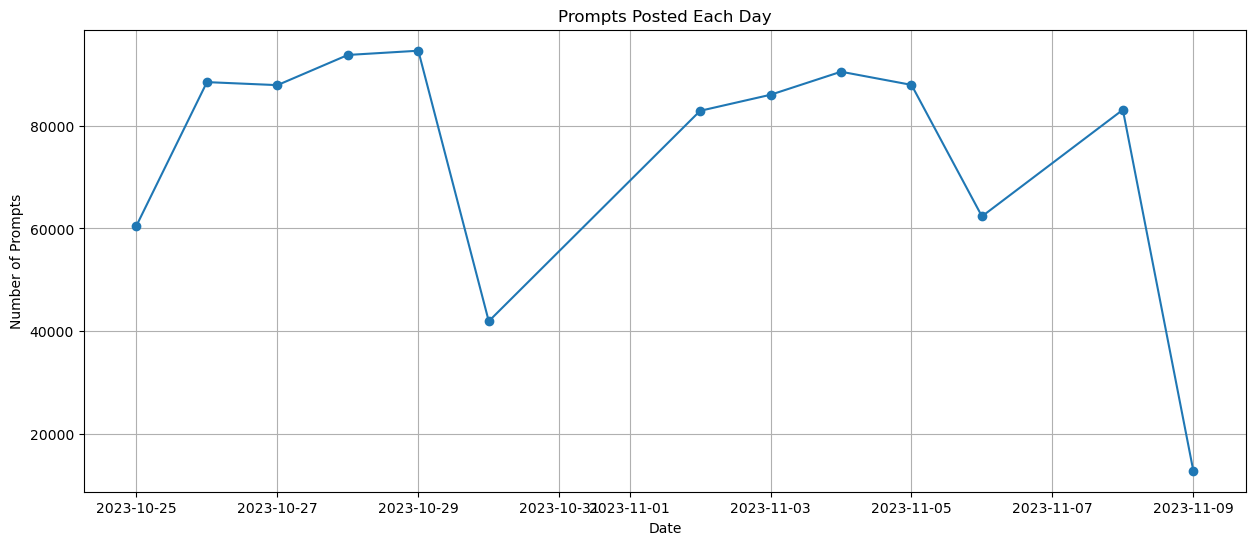

In [193]:
#Remove bad data days here. Did that way above jk.
#New graph.

plt.figure(figsize=(15, 6))
dailyPrompts.plot(kind="line", marker="o", linestyle="-")
plt.title("Prompts Posted Each Day")
plt.xlabel("Date")
plt.ylabel("Number of Prompts")
plt.grid(True)
plt.show()

In [38]:
userActiveDays = dailyActivity.groupby("user")["date"].nunique()
userActiveDays
#Redo user activity with clean data.

user
1000051693758718053    1
1000059165928079523    2
1000095457097289780    2
1000142097837457519    4
1000242258370633740    1
                      ..
999895176619237436     5
999925241939759134     4
999965352928751627     1
999966655985754122     1
999980663753150564     1
Name: date, Length: 24485, dtype: int64

**How many users prompted everyday?**

In [39]:
#When there's a day with only 5 prompts, ofc there's going to be 0 users prompting every day.
#We're better now.

activeEveryDayUsers = userActiveDays[userActiveDays == totalDays]
countUsersActiveEveryDay = activeEveryDayUsers.count()
countUsersActiveEveryDay
print(f"Number of users that prompted every tracked day: {countUsersActiveEveryDay}")

Number of users that prompted every tracked day: 11


### Variable Tracker
---

In [198]:
uniqueUsers
countUsersActiveEveryDay

totalPrompts 
uniquePrompts 
numUniquePrompts
imageOnlyPrompts


#Big numbers
print(f"Number of unique users: {uniqueUsers}")
print(f"Total number of Prompts: {totalPrompts}")
print(f"Number of unique prompts: {numUniquePrompts}")
print(f"There are {repeatedPrompts} total repeated prompts")

print(f"Number of prompts with only image references: {numImageOnlyPrompts}")
print(f"Number of unique prompts with only image references: {numUImagePrompts}")

#Fun numbers
print(f"Number of users that prompted every tracked day: {countUsersActiveEveryDay}")


Number of unique users: 24485
Total number of Prompts: 973117
Number of unique prompts: 187893
There are 785224 total repeated prompts
Number of prompts with only image references: 20088
Number of unique prompts with only image references: 3891
Number of users that prompted every tracked day: 11


## Interactive Prompt Viewer
---

In [ ]:
promptLabel = HTML()

def showRandomPrompt():
    randomPrompt = np.random.choice(uniquePrompts)  
    promptLabel.value = f'<pre>{randomPrompt}</pre>'

button = Button(description=" Show Random Prompt", layout=Layout(width="auto"), icon="lightbulb")

# Event handler for the button's on_click event
def onButtonClicked(b):
    showRandomPrompt()

button.on_click(onButtonClicked)
display(button)
display(promptLabel)
showRandomPrompt() 

## Total Prompt # + Daily Total Visual
---

In [182]:
def totalPromptGraph():
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=dailyPrompts.index,  
        y=dailyPrompts.values,
        name='Total Prompts Posted Each Day',
        marker=dict(color='rgb(151,166,196)')
    ))
    
    fig.update_layout(
        title=f"{totalPrompts:,} Prompts were Successfully Generated by {uniqueUsers:,} Users Across 13 Days",
        
        #xaxis_title="2023",
        autosize=False,
        width=900,
        height=600,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=6
        ),
    hoverlabel=dict(
            bgcolor="white", 
            font_size=15, 
        )
    )
    
    fig.update_xaxes(showgrid=False, tickvals=dailyPrompts.index, tickformat="%m-%d")
    fig.update_yaxes(showgrid=False)
    #fig.update_layout(template="simple_white")
    
    fig.show()

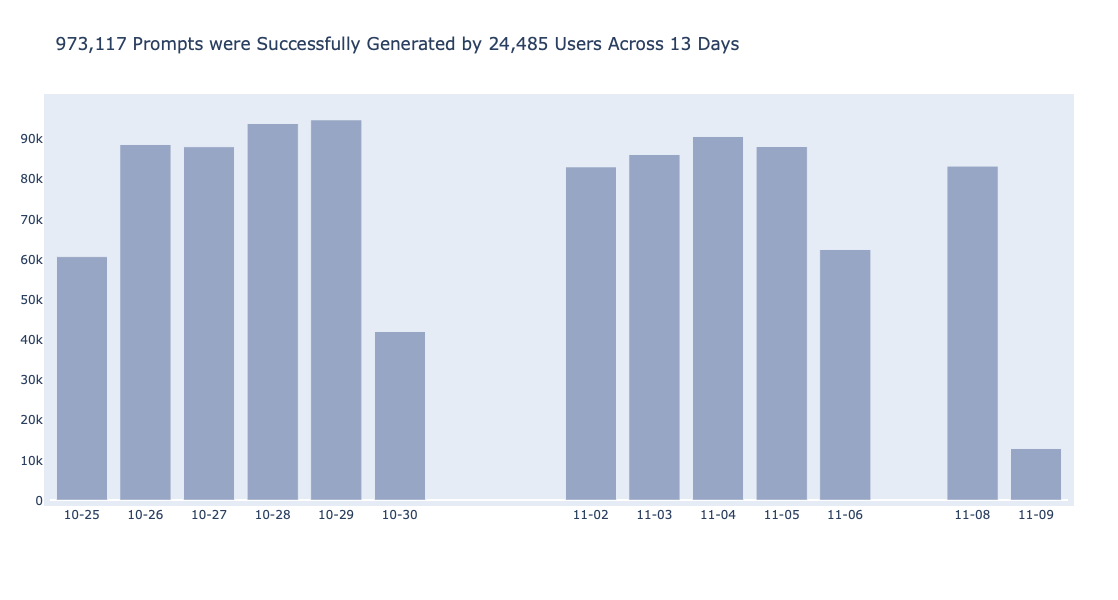

In [ ]:


fig1 = go.Figure()

fig1.add_trace(go.Bar(
    x=uniquePromptsByDate.index,  
    y=uniquePromptsByDate.values,
    name="Total Prompts Posted Each Day",
    marker=dict(color='rgb(56,72,96)')
))

fig1.update_layout(
    title=f"{numUniquePrompts:,} Unique Prompts were Successfully Generated by {uniqueUsers:,} Users Across 13 Days",
    
    #xaxis_title="2023",
    autosize=False,
    width=900,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=6
    ),
hoverlabel=dict(
        bgcolor="white", 
        font_size=15, 
    )
)

fig1.update_xaxes(showgrid=False, tickvals=dailyPrompts.index, tickformat="%m-%d")
fig1.update_yaxes(showgrid=False)



In [187]:
def totalPromptOverlay():
    fig2 = go.Figure()
    
    fig2.add_trace(go.Bar(
        x=dailyPrompts.index,  
        y=dailyPrompts.values,
        name="Total Daily Prompts",
        marker=dict(color='rgb(151,166,196)')
    ))
    
    
    fig2.add_trace(go.Bar(
        x=uniquePromptsByDate.index,  
        y=uniquePromptsByDate.values,
        name='Total Unique Daily Prompts',
        marker=dict(color='rgb(56,72,96)')
    ))
    
    fig2.update_layout(
        title=f"Of Those {totalPrompts:,} Prompts, {numUniquePrompts:,} were Unique",
        autosize=False,
        width=900,
        height=600,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=6
        ),
        hoverlabel=dict(
            bgcolor="white", 
            font_size=15, 
        ),
        barmode="overlay",
        legend=dict(
            yanchor="top",
            y=-0.2,
            xanchor="center",
            x=0.5
        )
    )
    
    fig2.update_xaxes(showgrid=False, tickvals=dailyPrompts.index, tickformat="%m-%d")
    fig2.update_yaxes(showgrid=False)
    
    fig2.show()

In [195]:
def percentUniqueGraph():

    fig4 = go.Figure(data=[go.Pie(
        labels=['Total Prompts', 'Unique Prompts'],
        values=[totalPrompts, numUniquePrompts],
        pull=[0, 0.2],
        marker=dict(colors=['rgb(151,166,196)', 'orange'])
    )])
    
    fig4.update_layout(
        title="That's Only 16.2%",
        autosize=False,
        width=500,
        height=500,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
    
    fig4.show()

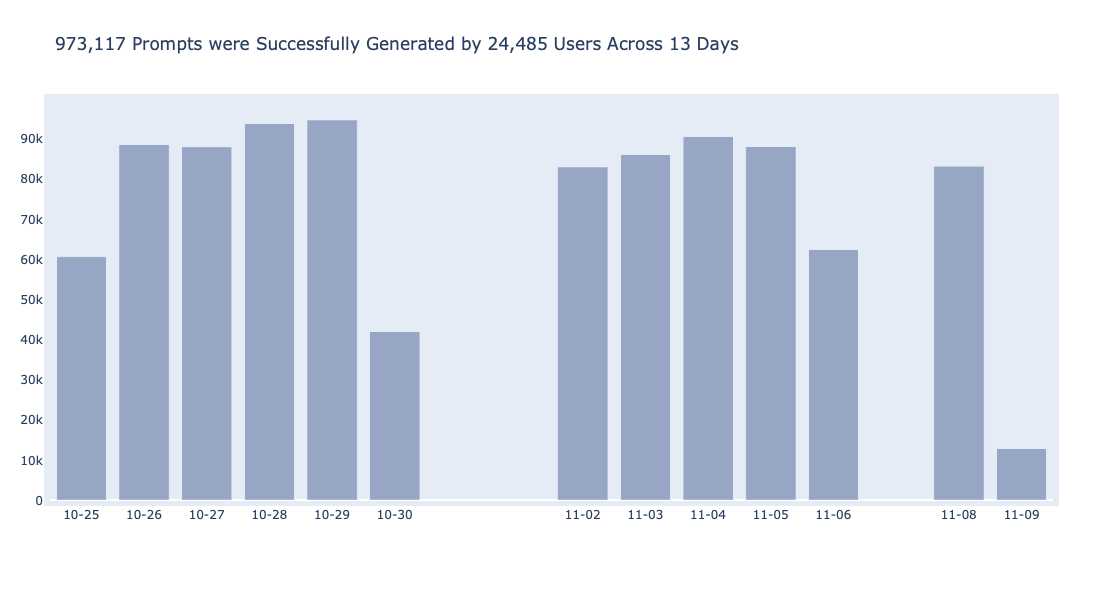

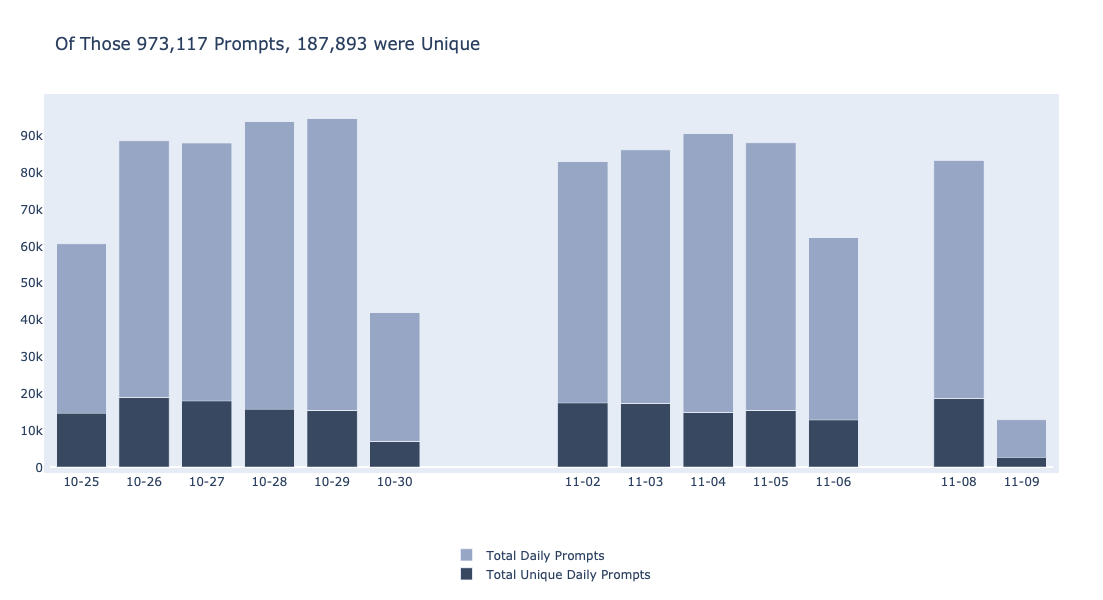

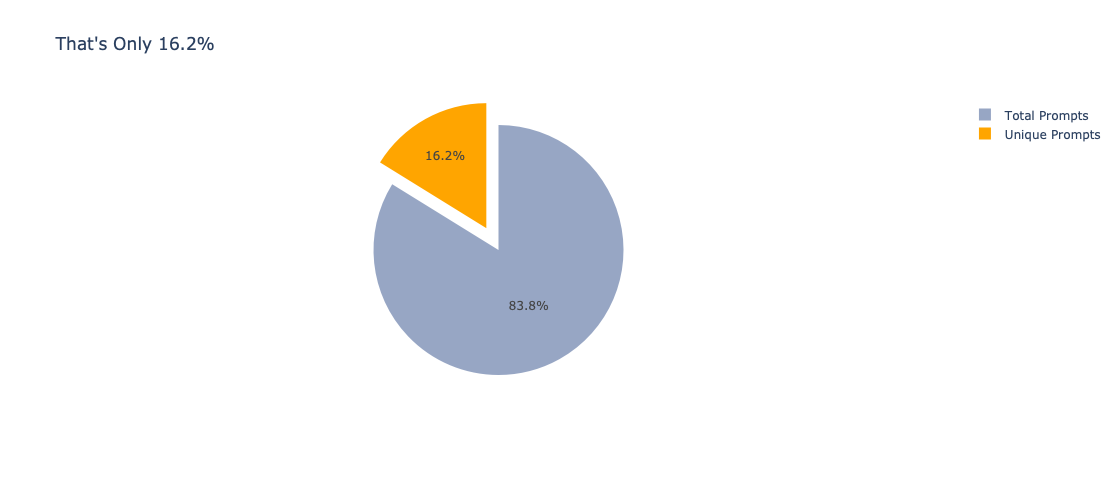

In [196]:
totalPromptGraph()
totalPromptOverlay()
percentUniqueGraph()

## Visuals
---

In [195]:
dayTest = pd.Timestamp('2023-10-26')
filteredData = promptDF[promptDF['date'] == dayTest.date()]


In [196]:
filteredData.head()

,prompt,user,timestamp,date
283361,"green leafy, trees, bushes, mossy stonework, c...",1006280181255770262,2023-10-26 00:00:01.580000+00:00,2023-10-26
283360,"green leafy, trees, bushes, mossy stonework, c...",1006280181255770262,2023-10-26 00:00:03.477000+00:00,2023-10-26
637378,"dnd, oil painting, ink, very detailed, princes...",1138795730660765726,2023-10-26 00:00:05.917000+00:00,2023-10-26
97071,"dnd, oil painting, ink, very detailed, princes...",1138795730660765726,2023-10-26 00:00:05.917000+00:00,2023-10-26
413893,"dnd, oil painting, ink, very detailed, princes...",1138795730660765726,2023-10-26 00:00:05.917000+00:00,2023-10-26


In [ ]:
promptDF["seconds"] = promptDF["timestamp"].dt.hour * 3600 + promptDF["timestamp"].dt.minute * 60 + promptDF["timestamp"].dt.second


fig = go.Figure(data=[go.Histogram(x=promptDF['seconds'], nbinsx=24*60,  # Start with minute bins
                                   marker_color='blue')])


fig.update_layout(
    title='Interactive Histogram of Prompts by Minute',
    xaxis_title='Seconds in Day',
    yaxis_title='Number of Prompts',
    bargap=0.2
)

# Show the plot
fig.show()


In [ ]:
fig = go.Figure()

# Add trace
fig.add_trace(go.Histogram(x=promptDF['seconds'], xbins=dict(
    start=0,
    end=86400,
    size=60  # Initial bin size (60 seconds)
), marker_color='blue'))

# Add slider for dynamic binning
fig.update_layout(
    sliders=[
        {
            'pad': {"t": 60},
            'currentvalue': {"prefix": "Bin size (seconds): "},
            'steps': [
                {'method': 'restyle', 'label': '1s', 'args': [{'xbins.size': 1}]},
                {'method': 'restyle', 'label': '10s', 'args': [{'xbins.size': 10}]},
                {'method': 'restyle', 'label': '30s', 'args': [{'xbins.size': 30}]},
                {'method': 'restyle', 'label': '60s', 'args': [{'xbins.size': 60}]},
                {'method': 'restyle', 'label': '300s', 'args': [{'xbins.size': 300}]},
                {'method': 'restyle', 'label': '600s', 'args': [{'xbins.size': 600}]}
            ]
        }
    ]
)

# Update the layout and titles
fig.update_layout(
    title='Interactive Histogram of Prompts with Dynamic Binning',
    xaxis_title='Seconds in Day',
    yaxis_title='Number of Prompts',
    bargap=0.2
)

# Show the plot
fig.show()


In [ ]:


specific_day = pd.to_datetime('2023-10-25').date()  
filtered_data = promptDF[promptDF['date'] == specific_day]

filtered_data['secSinceMidnight'] = (filtered_data['timestamp'].dt.hour * 3600 +
                                           filtered_data['timestamp'].dt.minute * 60 +
                                           filtered_data['timestamp'].dt.second)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(filtered_data['secSinceMidnight'], np.random.rand(len(filtered_data)), alpha=0.05)
plt.title('Activity Distribution for October 25, 2023')
plt.xlabel('Seconds Since Midnight')
plt.ylabel('Random Jitter for Visualization')
plt.xlim([0, 86400])  

plt.gca().set_xticks([i * 3600 for i in range(25)])  # Set ticks every hour
plt.gca().set_xticklabels([f'{i}:00' for i in range(25)])  # Label ticks by hour
plt.xticks(rotation=45)
plt.grid(False)
plt.show()



In [197]:

specific_day = '2023-10-25'
daily_data = promptDF[promptDF['date'] == pd.to_datetime(specific_day).date()]

# Create bins for every hour (3600 seconds)
bins = np.linspace(0, 86400, 25)  # 24 hours, 25 edges
hist, bin_edges = np.histogram(daily_data['secSinceMidnight'], bins=bins)

# Normalize the histogram to get values between 0 and 1 for color mapping
hist_norm = hist / hist.max()

cmap = plt.get_cmap('viridis')  
colors = cmap(hist_norm) 

plt.figure(figsize=(12, 4))
plt.bar(range(len(hist)), [1]*len(hist), color=colors, width=1, edgecolor='black')
plt.xticks(ticks=np.arange(len(bin_edges)-1), labels=[f'{int(edge/3600)}h' for edge in bin_edges[:-1]], rotation=45)
plt.yticks([])
plt.colorbar(plt.cm.ScalarMappable(norm=mcolors.Normalize(hist.min(), hist.max()), cmap=cmap), orientation='horizontal')
plt.title('Density of Prompts by Hour')
plt.show()



KeyError: 'secSinceMidnight'

In [1]:
unique_days = promptDF['date'].unique()
figures = []
for day in unique_days:
    day_data = promptDF[promptDF['date'] == day]
    fig = plot_daily_histogram(day_data)
    figures.append(fig)  # Optionally store to display later or save
    fig.show() 

NameError: name 'promptDF' is not defined

In [56]:
def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

In [60]:
#Just faffing about with using simple usuals to display the bigger data points.
#These styles should be applying but they're not and that's weird.



header1 = create_expanded_button('Midjourney Prompts', 'success')
header1.style.font_size = "24"
header1.style.font_style = "bold"

left_button = create_expanded_button(f"Unique Users: {uniqueUsers}", 'info')
center_button = create_expanded_button(f"Total Prompts: {checkTotal}", 'warning')
right_button = create_expanded_button(f"Unique Prompts: {numUniquePrompts}", 'info')
footer_button = create_expanded_button('Footer', 'success')

AppLayout(header=header1,
          left_sidebar=left_button,
          center=center_button,
          right_sidebar=right_button,
          footer=None)

AppLayout(children=(Button(button_style='success', description='Midjourney Prompts', layout=Layout(grid_area='…

In [61]:
header1.style.font_size = "50"
header1.style.button_color = 'lightgreen'
header1

Button(button_style='success', description='Midjourney Prompts', layout=Layout(grid_area='header', height='aut…

In [59]:

grid = GridspecLayout(4, 3, height='300px')
grid[:3, 1:] = create_expanded_button('Word Cloud', 'info')
grid[:, 0] = create_expanded_button('Stats', 'info')
grid[3, 1] = create_expanded_button('Drop Down 1 - Day', 'info')
grid[3, 2] = create_expanded_button('Slider', 'info')

grid

#

GridspecLayout(children=(Button(button_style='info', description='Word Cloud', layout=Layout(grid_area='widget…

## NLP???
---

Allegedly [Textblob](https://textblob.readthedocs.io/en/dev/index.html) is a decent beginner natural language processor. I keep seeing NLPs pop up anytime I search for information related to text analysis.